In [1]:
import os
import os.path as op
import numpy as np
import pandas as pd
import mne
from closedloop.data.utils.utils import brainvision_reader, brainvision_loader

import matplotlib
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

In [2]:
test_dir = '/home/jerry/python_projects/space/closedloop/test_data/prove_closedloop/lsl_tests'
fnames_test = [op.join(test_dir, f'test_{n}.csv') for n in range(1, 4)]
fnames_idx = [op.join(test_dir, f'test_idx_{n}.csv') for n in range(1, 4)]

In [3]:
csv_tests = [pd.read_csv(fnt, index_col=0) for fnt in fnames_test]
csv_idx = [pd.read_csv(fni, index_col=0) for fni in fnames_idx]

In [4]:
clean_tests = []
for ct, ci in zip(csv_tests, csv_idx):
    delays = []
    dout = False
    din = False
    in_count = 0
    for i in range(len(ct)):
        if ct.loc[i][1] == 'out':
            _dout = ct.loc[i].to_list()
            dout = True
        elif ct.loc[i][1] == 'in':
            _din = ct.loc[i].to_list()
            din = True
            
        if dout and din:
            didx = ci.loc[in_count].to_list()
            _didx = (33 - didx[0]) * 0.002
            delays.append([_dout[-1], _din[-1], _didx])
            dout = False
            din = False
            in_count += 1
            
    clean_tests.append(np.vstack(delays))
    all_clean_tests = np.vstack(clean_tests)


/tmp/ipykernel_25719/3383651740.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if ct.loc[i][1] == 'out':
/tmp/ipykernel_25719/3383651740.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif ct.loc[i][1] == 'in':


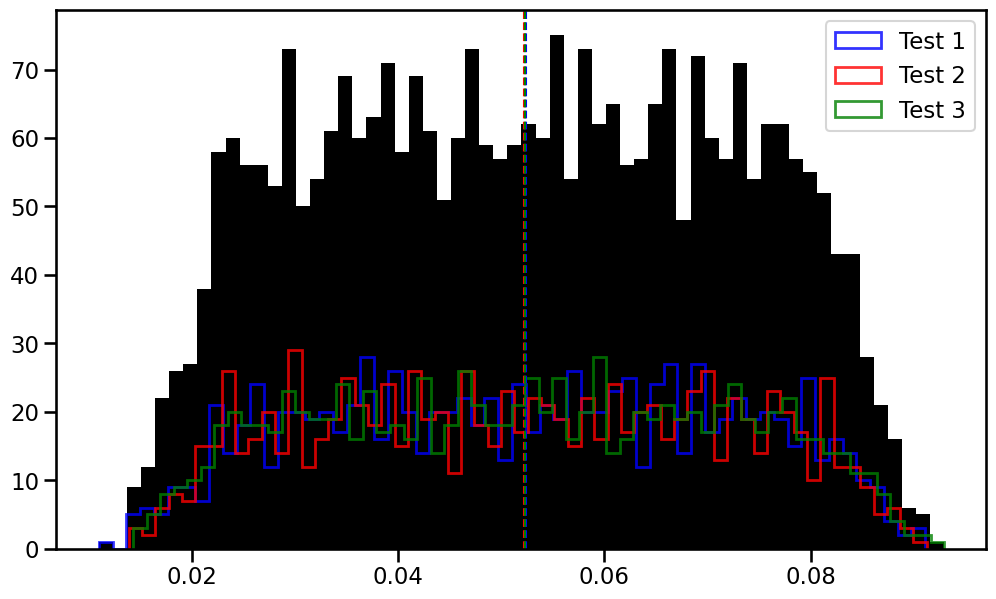

In [5]:
%matplotlib inline
colors = ['b', 'r', 'g']
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
ax.hist(all_clean_tests[:, 1] - all_clean_tests[:, 0], bins=60, color='k', alpha=1., histtype='bar', rasterized=True)
for i, ct in enumerate(clean_tests):
    ax.hist(ct[:, 1] - ct[:, 0], bins=60, lw=2., color=colors[i], alpha=.8, histtype='step', rasterized=True, label=f'Test {i+1}')
for i, ct in enumerate(clean_tests):
    ax.axvline(np.mean(ct[:, 1] - ct[:, 0]), color=colors[i], ls='--', lw=1.5)
plt.legend()
plt.savefig('/home/jerry/python_projects/space/closedloop/test_data/prove_closedloop/total_delays.svg')
plt.savefig('/home/jerry/python_projects/space/closedloop/test_data/prove_closedloop/total_delays.png')
plt.show(block=False)

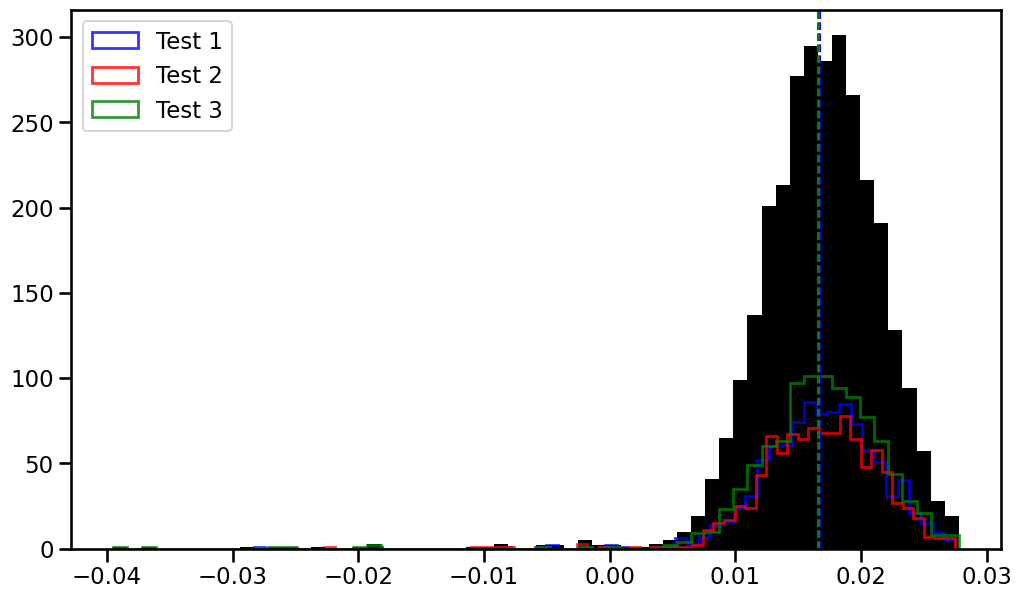

In [6]:
%matplotlib inline
colors = ['b', 'r', 'g']
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
ax.hist((all_clean_tests[:, 1]-all_clean_tests[:, 0])-all_clean_tests[:, 2], 
        bins=60, color='k', alpha=1., histtype='bar', rasterized=True)
for i, ct in enumerate(clean_tests):
    ax.hist((ct[:, 1] - ct[:, 0]) - ct[:, 2], bins=60, lw=2., color=colors[i], 
            alpha=.8, histtype='step', rasterized=True, label=f'Test {i+1}')
for i, ct in enumerate(clean_tests):
    ax.axvline(np.mean((ct[:, 1] - ct[:, 0]) - ct[:, 2]), color=colors[i], 
               ls='--', lw=1.5)
plt.legend()
plt.savefig('/home/jerry/python_projects/space/closedloop/test_data/prove_closedloop/real_delays.svg')
plt.savefig('/home/jerry/python_projects/space/closedloop/test_data/prove_closedloop/real_delays.png')
plt.show(block=False)

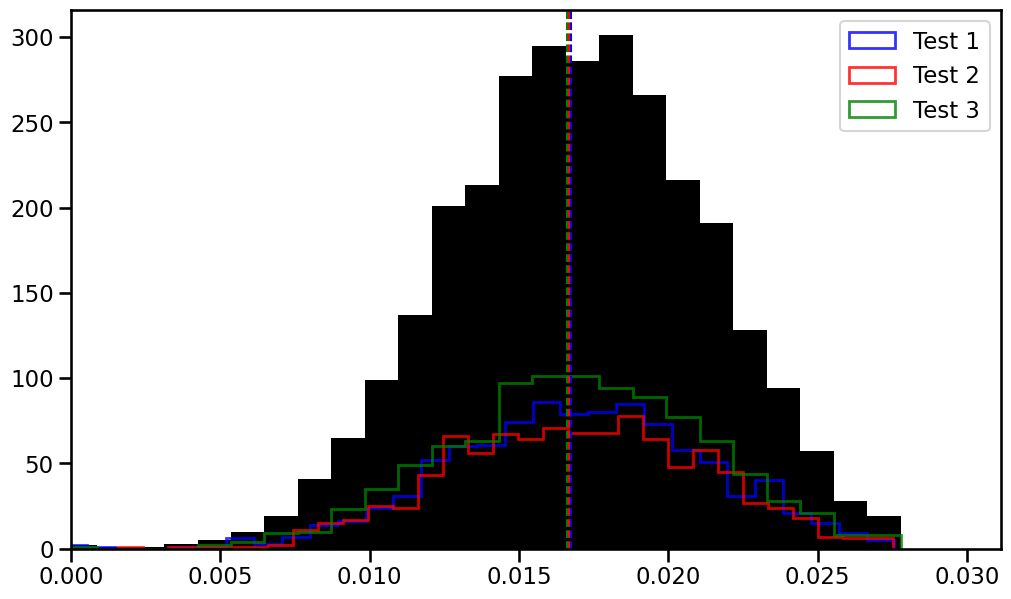

In [7]:
%matplotlib inline
colors = ['b', 'r', 'g']
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
ax.hist((all_clean_tests[:, 1]-all_clean_tests[:, 0])-all_clean_tests[:, 2], 
        bins=60, color='k', alpha=1., histtype='bar', rasterized=True)
for i, ct in enumerate(clean_tests):
    ax.hist((ct[:, 1] - ct[:, 0]) - ct[:, 2], bins=60, lw=2., color=colors[i], 
            alpha=.8, histtype='step', rasterized=True, label=f'Test {i+1}')
for i, ct in enumerate(clean_tests):
    ax.axvline(np.mean((ct[:, 1] - ct[:, 0]) - ct[:, 2]), color=colors[i], 
               ls='--', lw=1.5)
ax.set_xlim(xmin=0)
plt.legend()
plt.savefig('/home/jerry/python_projects/space/closedloop/test_data/prove_closedloop/real_delays_zoom.svg')
plt.savefig('/home/jerry/python_projects/space/closedloop/test_data/prove_closedloop/real_delays_zoom.png')
plt.show(block=False)

In [8]:
def create_raw(vhdr_fnames, events_id, raw_dir, fif_fname):

    raws, eves = [], []

    for vhdr_fname in vhdr_fnames:
        # Read brainvision raw (no memory loading)
        raw = brainvision_reader(vhdr_fname)
        # Extracting salient events
        try:
            events, event_dict = mne.events_from_annotations(
                raw, event_id=events_id)
        except:
            continue
        
        # Adding features to data
        raw = brvs_pipeline(raw)

        raws.append(raw)
        eves.append(events)

    # Concatenate raws and events
    raw, events = mne.concatenate_raws(raws=raws, preload=True, 
                                       events_list=eves, on_mismatch='raise',
                                       verbose=False)
    # Deleting list containing raws (reduce memory usage)
    del raws

    # Creating raw files directory
    os.makedirs(raw_dir, exist_ok=True)

    # Saving the raw fif file
    raw.save(op.join(raw_dir, '{0}-raw.fif'.format(fif_fname)),
             split_naming='neuromag', overwrite=True)
    # Saving events
    mne.write_events(op.join(raw_dir, '{0}-eve.fif'.format(fif_fname)), 
                            events, overwrite=True)
    
    return


def brvs_pipeline(raw_data):
    # Load data in memory
    brainvision_loader(raw_data)
    # Some subjects have extra BIP channels we should drop
    # ch_drop = ['BIP' + str(b) for b in list(range(4, 25))]
    # crop_raw = crop_raw.drop_channels(ch_drop, on_missing='warn')
    # Adding the reference channel
    raw_data.add_reference_channels('Z12Z')
    # Renaming and assing a type to autonomic channels
    raw_data.rename_channels(mapping={'BIP1': 'EMG',
                                      'BIP2': 'ECG',
                                      'BIP3': 'RES'})
    raw_data.set_channel_types(mapping={'EMG': 'emg',
                                        'ECG': 'ecg',
                                        'RES': 'resp'})
    # Referencing and renaming the vertical ocular channel
    raw_data = mne.set_bipolar_reference(raw_data, 'VEOGR', 'R1Z', 
                                         ch_name='VEOG',
                                         drop_refs=False, 
                                         copy='False')
    # Deleting the old unreferenced VEOGR channel
    raw_data.drop_channels(ch_names=['VEOGR'])
    # Creating the horizontal ocular channel 
    raw_data = mne.set_bipolar_reference(raw_data, 'L1G', 'R1G', 
                                         ch_name='HEOG', 
                                         drop_refs=False, 
                                         copy='False')
    # Assing type to ocular channels
    raw_data.set_channel_types(mapping={'VEOG': 'eog',
                                        'HEOG': 'eog'})

    return raw_data


test_recordings = '/home/jerry/python_projects/space/closedloop/test_data/prove_closedloop/2024-09-25'
vhdr = ['__2024-09-25_17-14-30.vhdr', '__2024-09-25_17-31-49.vhdr', '__2024-09-25_17-45-17.vhdr']
fnames_vhdr = [op.join(test_recordings, _vhdr) for _vhdr in vhdr]
fname_raw = 'test_delays'
events_id = {'Stimulus/s22': 22}

create_raw(fnames_vhdr, events_id, test_recordings, fname_raw)


Extracting parameters from /home/jerry/python_projects/space/closedloop/test_data/prove_closedloop/2024-09-25/__2024-09-25_17-14-30.vhdr...
Setting channel info structure...
Used Annotations descriptions: ['Stimulus/s22']
Reading 0 ... 377963  =      0.000 ...   755.926 secs...


/home/jerry/python_projects/space/closedloop/closedloop/data/utils/utils.py:29: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_brainvision(vhdr_fname, scale=scale,


Location for this channel is unknown; consider calling set_montage() after adding new reference channels if needed. Applying a montage will only set locations of channels that exist at the time it is applied.
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=377964
    Range : 0 ... 377963 =      0.000 ...   755.926 secs
Ready.
Added the following bipolar channels:
VEOG
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=377964
    Range : 0 ... 377963 =      0.000 ...   755.926 secs
Ready.
Added the following bipolar channels:
HEOG
Extracting parameters from /home/jerry/python_projects/space/closedloop/test_data/prove_closedloop/2024-09-25/__2024-09-25_17-31-49.vhdr...
Setting channel info structure...
Used Annotations descriptions: ['Stimulus/s22']
Reading 0 ... 299870  =      0.000 ...   599.740 secs...


/home/jerry/python_projects/space/closedloop/closedloop/data/utils/utils.py:29: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_brainvision(vhdr_fname, scale=scale,


Location for this channel is unknown; consider calling set_montage() after adding new reference channels if needed. Applying a montage will only set locations of channels that exist at the time it is applied.
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=299871
    Range : 0 ... 299870 =      0.000 ...   599.740 secs
Ready.
Added the following bipolar channels:
VEOG
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=299871
    Range : 0 ... 299870 =      0.000 ...   599.740 secs
Ready.
Added the following bipolar channels:
HEOG
Extracting parameters from /home/jerry/python_projects/space/closedloop/test_data/prove_closedloop/2024-09-25/__2024-09-25_17-45-17.vhdr...
Setting channel info structure...
Used Annotations descriptions: ['Stimulus/s22']
Reading 0 ... 318467  =      0.000 ...   636.934 secs...


/home/jerry/python_projects/space/closedloop/closedloop/data/utils/utils.py:29: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_brainvision(vhdr_fname, scale=scale,


Location for this channel is unknown; consider calling set_montage() after adding new reference channels if needed. Applying a montage will only set locations of channels that exist at the time it is applied.
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=318468
    Range : 0 ... 318467 =      0.000 ...   636.934 secs
Ready.
Added the following bipolar channels:
VEOG
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=318468
    Range : 0 ... 318467 =      0.000 ...   636.934 secs
Ready.
Added the following bipolar channels:
HEOG
Overwriting existing file.
Writing /home/jerry/python_projects/space/closedloop/test_data/prove_closedloop/2024-09-25/test_delays-raw.fif
Closing /home/jerry/python_projects/space/closedloop/test_data/prove_closedloop/2024-09-25/test_delays-raw.fif
[done]
Overwriting existing file.


In [27]:
raw_fname = op.join(test_recordings, 'test_delays-raw.fif')
eve_fname = op.join(test_recordings, 'test_delays-eve.fif')
raw = mne.io.read_raw_fif(raw_fname)
eve = mne.read_events(eve_fname)

Opening raw data file /home/jerry/python_projects/space/closedloop/test_data/prove_closedloop/2024-09-25/test_delays-raw.fif...
    Range : 0 ... 996302 =      0.000 ...  1992.604 secs
Ready.


Using matplotlib backend: QtAgg


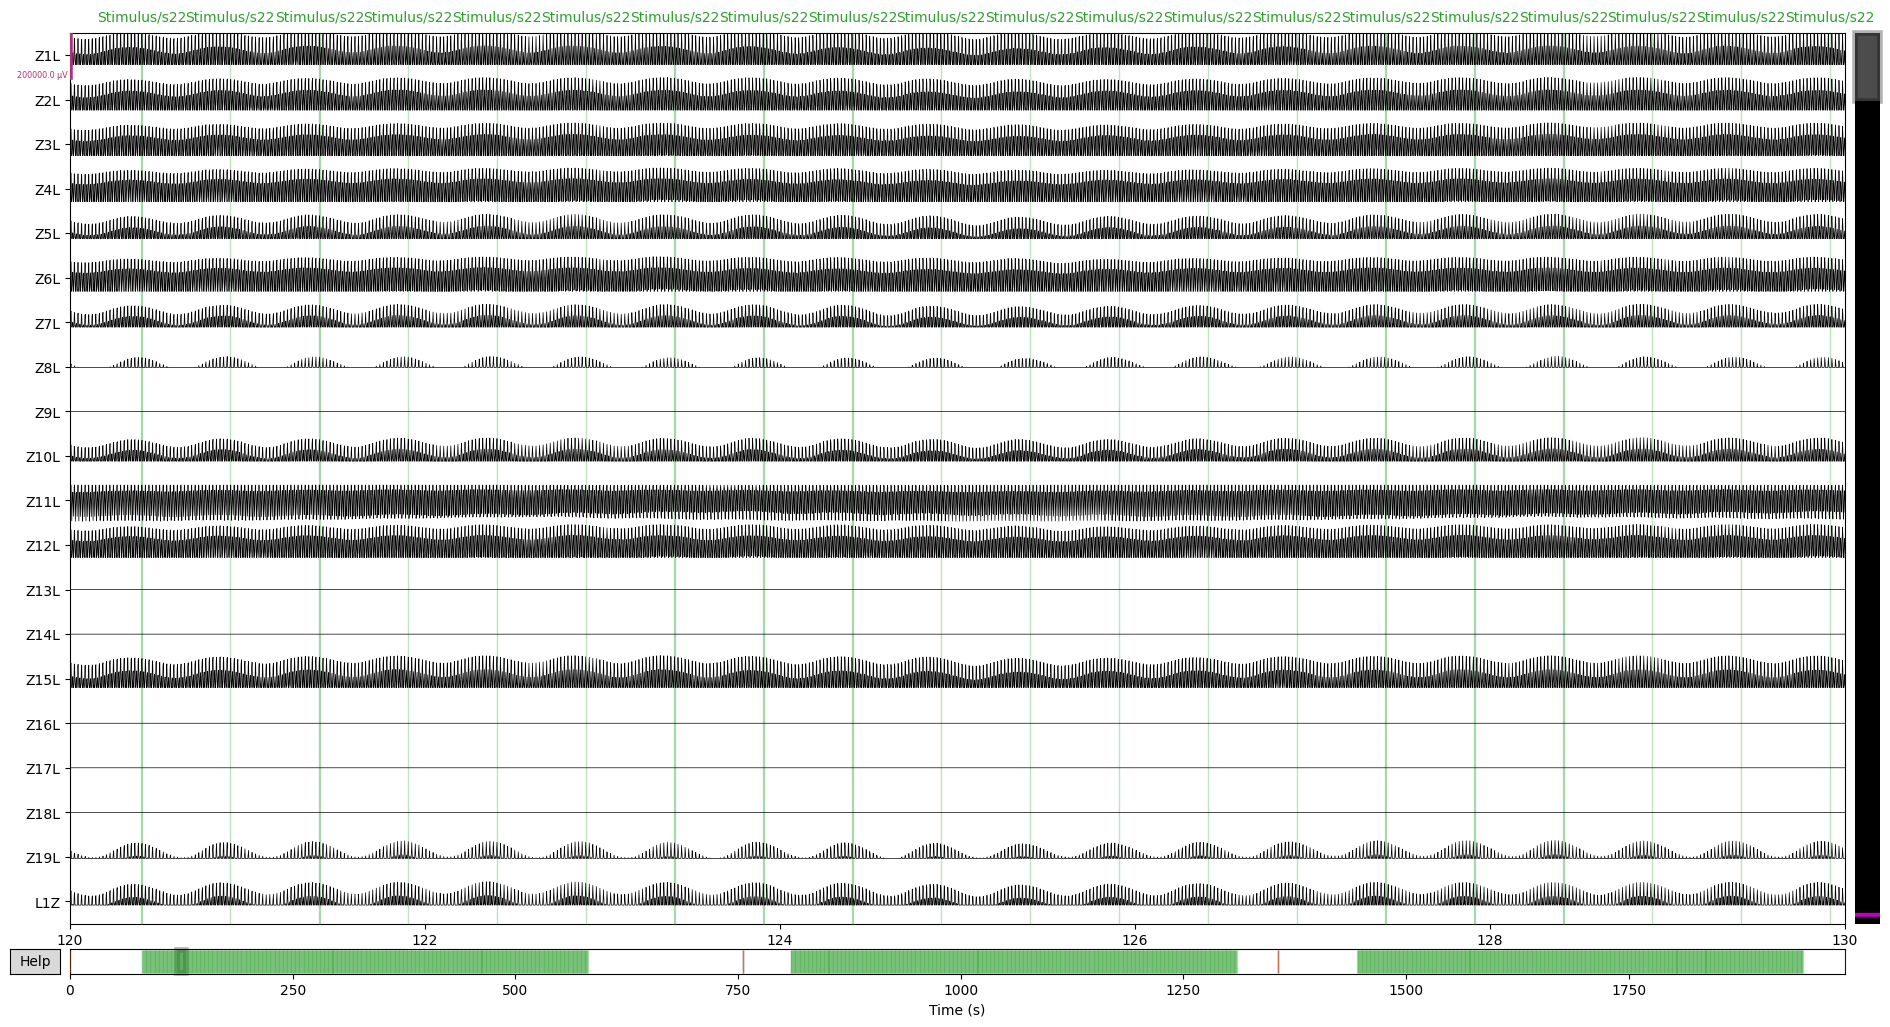

Channels marked as bad:
none


In [23]:
sns.reset_defaults()
%matplotlib

matplotlib.use('QtAgg')
raw.plot(duration=10., start=120., n_channels=20, bgcolor='w', 
         scalings={'eeg': 1e-1}, show=True, block=False, 
         highpass=None, lowpass=None)


In [30]:
np.diff(eve[:, 0])

array([250, 251, 250, ..., 250, 250, 251])